# Two-level AMG+ for 1D Helmholtz / Repetitive
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [182]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [523]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = True #. False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 2
# Set # sweeps manually here.
num_sweeps_on_vectors = 1000 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [524]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.363e+00                    4.470e-01    3.049
INFO     1     5.393e-01 (0.396) [0.396]    2.739e-01    1.977 (0.647)
INFO     2     2.250e-01 (0.418) [0.407]    2.075e-01    1.098 (0.554)
INFO     3     1.019e-01 (0.453) [0.422]    1.770e-01    0.592 (0.536)
INFO     4     5.285e-02 (0.518) [0.444]    1.592e-01    0.347 (0.581)
INFO     5     3.171e-02 (0.599) [0.472]    1.475e-01    0.229 (0.652)
INFO     6     2.152e-02 (0.677) [0.501]    1.389e-01    0.168 (0.724)
INFO     7     1.591e-02 (0.738) [0.530]    1.322e-01    0.132 (0.780)
INFO     8     1.245e-02 (0.782) [0.556]    1.268e-01    0.109 (0.819)
INFO     9     1.015e-02 (0.815) [0.580]    1.224e-01    0.092 (0.848)
INFO     10    8.505e-03 (0.839) [0.602]    1.185e-01    0.080 (0.869)
INFO     11    7.289e-03 (0.858) [0.622]    1.152e-01    0.070 (0.885)
INFO     12    6.357e-03 (0.873) [0.640]    1.123e-01    0.063 (0.898)
INFO 

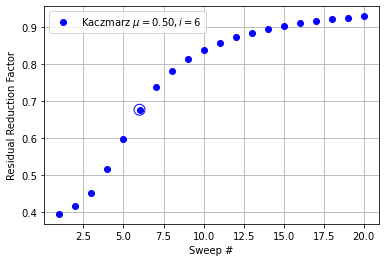

In [525]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [526]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 2 ideal TVs


### Coarsening: Fixed (4/2)

In [527]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

[[ 0.507  0.503  0.498  0.492]
 [ 0.637  0.245 -0.202 -0.702]]


,0,1,2,3,4,5,6,7,8,9
0,0.51,0.50,0.50,0.49,0.00,0.00,0.00,0.00,0.00,0.00
1,0.64,0.25,-0.20,-0.70,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.51,0.50,0.50,0.49,0.00,0.00
3,0.00,0.00,0.00,0.00,0.64,0.25,-0.20,-0.70,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.50


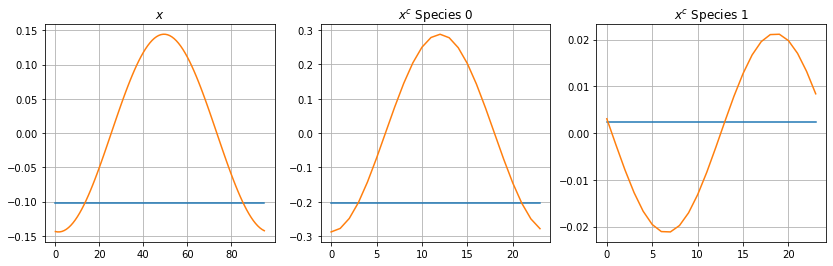

In [528]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [529]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.313 0.093 0.057 0.028 0.017 0.015]


### Interpolation $P = R^T$

In [530]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 3.17


### Interpolation by LS Fitting

In [532]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml,  nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6
Mock,nan,nan,nan,nan,nan,0.31,0.09,0.06,0.03,0.02,0.01
P=R^T,nan,nan,nan,nan,nan,0.57,0.43,0.50,0.46,0.42,0.39
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.52,0.41,0.47,0.45,0.39,0.37
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.57,0.27,0.27,0.31,0.25,0.22
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.58,0.26,0.23,0.26,0.20,0.16
R A P caliber 2,1.00,2.00,192.00,1.20,0.04,0.51,0.40,0.47,0.46,0.40,0.38
R A P caliber 3,1.00,3.00,288.00,1.20,0.03,1.52,1.19,1.55,1.16,1.15,0.80
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,1.34,2.07,1.85,1.59,1.49,1.34


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [533]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,0.51,0.66
1,0.50,0.22
2,0.50,-0.22
3,0.49,-0.68


A^1


,0,1,2,3,4,5
0,-0.58,-0.01,0.29,0.40,0.29,-0.42
1,-0.01,-1.79,-0.42,-0.58,0.40,-0.58


caliber 3 P


,0,1,2,3
0,0.47,0.55,0.00,0.03
1,0.53,0.32,0.00,-0.03
2,0.53,-0.35,-0.03,0.00
3,0.46,-0.57,0.03,0.00


A^1


,0,1,2,3,4,5,6,7
0,-0.45,-0.00,0.22,0.29,0.00,0.00,0.22,-0.31
1,-0.00,-1.37,-0.31,-0.39,0.00,0.00,0.29,-0.39


caliber 4 P


,0,1,2,3,4,5
0,0.46,0.53,0.00,0.00,0.05,-0.02
1,0.53,0.31,0.00,0.00,-0.02,-0.01
2,0.56,-0.40,-0.06,-0.05,0.00,0.00
3,0.45,-0.54,0.05,0.03,0.00,0.00


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.41,0.01,0.20,0.25,0.00,0.00,0.00,0.00,0.20,-0.28
1,0.01,-1.25,-0.28,-0.33,0.00,0.00,0.00,0.00,0.25,-0.33


R*A*P
caliber 2 P


,0,1
0,0.51,0.66
1,0.50,0.22
2,0.50,-0.22
3,0.49,-0.68


A^1


,0,1,2,3,4,5
0,-0.58,-0.01,0.29,0.40,0.29,-0.42
1,0.02,-1.78,-0.44,-0.59,0.38,-0.55


caliber 3 P


,0,1,2,3
0,0.47,0.55,0.00,0.03
1,0.53,0.32,0.00,-0.03
2,0.53,-0.35,-0.03,0.00
3,0.46,-0.57,0.03,0.00


A^1


,0,1,2,3,4,5
0,-0.50,-0.00,0.25,0.32,0.25,-0.35
1,0.01,-1.46,-0.36,-0.49,0.31,-0.46


caliber 4 P


,0,1,2,3,4,5
0,0.46,0.53,0.00,0.00,0.05,-0.02
1,0.53,0.31,0.00,0.00,-0.02,-0.01
2,0.56,-0.40,-0.06,-0.05,0.00,0.00
3,0.45,-0.54,0.05,0.03,0.00,0.00


A^1


,0,1,2,3,4,5
0,-0.46,-0.00,0.23,0.29,0.23,-0.31
1,0.00,-1.32,-0.31,-0.41,0.28,-0.39


### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 2.004e+01 RER 3.59218
INFO         1 |r| 3.911e+00 (0.19521) RER 0.72440 (0.20166) 5.399
INFO         2 |r| 7.164e-01 (0.18315) RER 0.12779 (0.17641) 5.606
INFO         3 |r| 1.429e-01 (0.19950) RER 0.02480 (0.19409) 5.762
INFO         4 |r| 2.777e-02 (0.19433) RER 0.00490 (0.19739) 5.673
INFO         5 |r| 5.310e-03 (0.19118) RER 0.00092 (0.18783) 5.774
INFO         6 |r| 1.057e-03 (0.19906) RER 0.00018 (0.19720) 5.828
INFO         7 |r| 2.321e-04 (0.21962) RER 0.00004 (0.21775) 5.878
INFO         8 |r| 5.475e-05 (0.23588) RER 0.00001 (0.24145) 5.743
INFO         9 |r| 1.293e-05 (0.23620) RER 0.00000 (0.22454) 6.041
INFO        10 |r| 2.980e-06 (0.23042) RER 0.00000 (0.24063) 5.785
INFO        11 |r| 6.853e-07 (0.22997) RER 0.00000 (0.23135) 5.750
INFO        12 |r| 1.628e-07 (0.23756) RER 0.00000 (0.24036) 5.683
INFO        13 |r| 3.975e-08 (0.24420) RER 0.00000 (0.24184) 5.739
INFO        14 |r| 9.569e-09 (0.24069) RER 0.00000 (0.24304) 5.684
INFO        15 |r| 2.

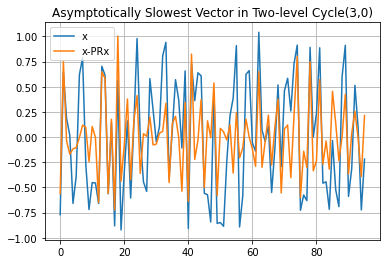

In [534]:
nu = 3
p = p_experiment[True][-1]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=False)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [535]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.    -0.004 -0.004 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.107 -0.107 -0.154]
1 lam [-0.    -0.004 -0.004 -0.017 -0.017 -0.039 -0.039 -0.069 -0.069 -0.108 -0.108 -0.156]


#### $P^T A Q$ Coarsening
This is not exactly $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil.

In [536]:
a = multilevel.finest_level.a
p = multilevel[1].p

pta = p.transpose().dot(a)
print("nnz in P^T*A stencil", pta[0].nnz)
i = 0
pta_vars = np.sort(pta[i].nonzero()[1])
print("center", i)
print("pta_vars", pta_vars)
print("stencil values", np.array(pta[i, pta[i].nonzero()[1]].todense()))
#pd.DataFrame(pta.todense()[:5])

# P^T*A*R^T sparsity pattern.
rap = pta.dot(R.transpose())
rap_vars = np.sort(rap[i].nonzero()[1])
print("rap_vars", rap_vars)

# Calculate fine and coarse level variable locations.
location = [None] * len(multilevel)
location[0] = np.arange(n)
location[1] = np.tile(np.add.reduceat(location[0], np.arange(0, n, aggregate_size)) / aggregate_size, (num_components, 1)).transpose().flatten()

fine_location, coarse_location = location[0:2]

# Find P^T*A fine and coarse var locations. Wrapping works on locations a well even
# though they are not integers (apply periodic B.C. so distances don't wrap around).
xf = hm.setup.sampling.wrap_index_to_low_value(fine_location[pta_vars], n)
xc = hm.setup.sampling.wrap_index_to_low_value(coarse_location[rap_vars], n)

# Find nearest neighbors of each fine P^T*A point (pta_vars).
# These are INDICES into the rap_vars array.
nbhr = np.argsort(np.abs(xf[:, None] - xc), axis=1)
print("nbhr", nbhr)

nnz in P^T*A stencil 12
center 0
pta_vars [ 0  1  2  3  4  5  6  7 92 93 94 95]
stencil values [[-0.421 -0.005 -0.137 -0.351  0.4    0.085 -0.037  0.002  0.005 -0.087  0.182  0.363]]
rap_vars [ 0  1  2  3 46 47]
nbhr [[0 1 4 5 2 3]
 [0 1 4 5 2 3]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [2 3 0 1 4 5]
 [2 3 0 1 4 5]
 [2 3 0 1 4 5]
 [2 3 0 1 4 5]
 [4 5 0 1 2 3]
 [4 5 0 1 2 3]
 [4 5 0 1 2 3]
 [4 5 0 1 2 3]]


In [551]:
caliber = 4
max_caliber = 6

nc = num_components
num_aggregates = int(np.ceil(a.shape[0] / aggregate_size))
num_coarse_vars = nc * num_aggregates
domain_size, num_test_functions = x.shape

# Prepare fine and coarse test matrices.
xc = R.dot(x)
residual = a.dot(x)

# Prepare sampled windows of x, xc, residual normn.
max_caliber = min(max_caliber, max(len(n) for n in nbhr))
num_windows = max(np.minimum(num_aggregates, (12 * max_caliber) // num_test_functions), 1)
x_disjoint_aggregate_t = hm.setup.sampling.get_windows_by_index(x, pta_vars, aggregate_size, num_windows)
xc_disjoint_aggregate_t = hm.setup.sampling.get_windows_by_index(xc, rap_vars, num_components, num_windows)

# Calculate residual norms.
index = pta_vars
stride = aggregate_size
residual_window_size = 3 * aggregate_size  # Good for 1D.
residual_window_offset = -(residual_window_size // 2)
r_norm_disjoint_aggregate_t = np.concatenate(tuple(
np.linalg.norm(
    residual[int(np.rint(np.mean(
        hm.setup.sampling.wrap_index_to_low_value(index + offset, n)
    ))) + residual_window_offset + 
             np.arange(residual_window_size) % residual.shape[0]],
    axis=0) 
    for offset in range(0, num_windows * stride, stride))) / residual_window_size ** 0.5
# In principle, each point in the aggregate should have a slightly shifted residual window, but we just take the
# same residual norm for all points for simplicity. Should not matter much.
r_norm_disjoint_aggregate_t = np.tile(r_norm_disjoint_aggregate_t[:, None], (len(index), ))

weight = np.clip(r_norm_disjoint_aggregate_t, 1e-15, None) ** (-1)
    
nbhr_for_caliber = [n[:caliber] for n in nbhr]

# Create folds.
num_examples = int(x_disjoint_aggregate_t.shape[0])
num_ls_examples = num_examples - num_test_examples
val_samples = int(0.2 * num_ls_examples)
fit_samples = num_examples - val_samples - num_test_examples

# Ridge regularization parameter (list of values).
alpha = np.array([0, 0.01, 0.1, 0.1, 1])

q = hm.setup.interpolation_ls_fit.create_interpolation_least_squares_ridge(
    x_disjoint_aggregate_t, xc_disjoint_aggregate_t, nbhr_for_caliber, weight, 
    alpha=alpha, fit_samples=fit_samples,
    val_samples=val_samples, test_samples=num_test_examples)

#x_disjoint_aggregate_t.shape, xc_disjoint_aggregate_t.shape, weight.shape

print("q", q.todense())

ptaq = pta[:num_components, pta_vars].dot(q)
print("ptaq", ptaq.todense())

print("ac", ac[10:12, 8:14].todense())

q [[ 0.463  0.532  0.     0.     0.043 -0.018]
 [ 0.528  0.314  0.     0.    -0.024 -0.01 ]
 [ 0.558 -0.401 -0.063 -0.053  0.     0.   ]
 [ 0.441 -0.528  0.054  0.042  0.     0.   ]
 [ 0.057 -0.045  0.448  0.507  0.     0.   ]
 [-0.02  -0.018  0.523  0.306  0.     0.   ]
 [-0.089  0.108  0.59  -0.015  0.     0.   ]
 [ 0.076 -0.088  0.414 -0.863  0.     0.   ]
 [ 0.053  0.033  0.     0.     0.456  0.821]
 [-0.035 -0.008  0.     0.     0.537  0.101]
 [-0.073 -0.07   0.     0.     0.568 -0.418]
 [ 0.063  0.058  0.     0.     0.432 -0.512]]
ptaq [[-0.392  0.     0.193  0.22   0.198 -0.259]
 [ 0.01  -1.226 -0.272 -0.314  0.242 -0.304]]
ac [[ 0.228 -0.308 -0.457 -0.003  0.228  0.288]
 [ 0.282 -0.394  0.005 -1.321 -0.31  -0.408]]


In [543]:
ac[10:12, 8:14].todense()

matrix([[ 0.228, -0.308, -0.457, -0.003,  0.228,  0.288],
        [ 0.282, -0.394,  0.005, -1.321, -0.31 , -0.408]])